In [124]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from math import log10, floor
import os
import glob
import matplotlib.pyplot as plt
import datetime

from relational_rnn_models import RelationalMemoryGenerator
from discriminator import RelGANDiscriminator

cuda = torch.cuda.is_available()

# Try setting the device to a GPU
device = torch.device("cuda:0" if cuda else "cpu")
print('Device:', device)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Device: cuda:0


In [125]:
def str_to_datetime(string):
    return datetime.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

In [152]:
icd_codes = pd.read_csv('D_ICD_DIAGNOSES.csv.gz', compression='gzip', index_col='ROW_ID')

date_time_events = pd.read_csv('DATETIMEEVENTS.csv.gz', compression='gzip', index_col='ROW_ID')

diagnoses = pd.read_csv('DIAGNOSES_ICD.csv.gz', compression='gzip', index_col='ROW_ID')

date_time_events['CHARTTIME'] = date_time_events['CHARTTIME'].map(str_to_datetime)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [161]:
subjects = pd.unique(date_time_events['SUBJECT_ID'])
print(len(subjects))

29185
2099-10-19 12:48:00
2209-08-07 16:52:00


In [170]:
li = np.zeros((len(subjects),), dtype=bool)
print(li.shape)

for i, s in enumerate(subjects):
    li1 = diagnoses['SUBJECT_ID'] == s 

    subject_diagnoses = diagnoses.loc[li1]
    
    if len(subject_diagnoses['HADM_ID'].unique()) > 1:
        li[i] = True
        
print(np.sum(li))
subjects = subjects[li]

(29185,)
6080


In [173]:
t0 = np.min(date_time_events['CHARTTIME'])
t1 = np.max(date_time_events['CHARTTIME'])
print(t0)
print(t1)

# TODO: create a sequence for a single patient


2099-10-19 12:48:00
2209-08-07 16:52:00


In [128]:
test_subject = date_time_events['SUBJECT_ID'].iloc[0]

li = diagnoses['SUBJECT_ID'] == test_subject 

subject_diagnoses = diagnoses.loc[li]

test_hadm = subject_diagnoses['HADM_ID'].iloc[0]
li2 = subject_diagnoses['HADM_ID'] == test_hadm

subject_diagnoses = subject_diagnoses.loc[li2]
print(subject_diagnoses)

li = date_time_events['SUBJECT_ID'] == test_subject

events = date_time_events.loc[li].copy()
events = events.sort_values('CHARTTIME')
events['CHARTTIME'] = events['CHARTTIME'] - events['CHARTTIME'].iloc[0]
print(events)

#print(diagnoses)

        SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
ROW_ID                                        
85503         7657   121183      1.0     V3000
85504         7657   121183      2.0     76515
85505         7657   121183      3.0       769
85506         7657   121183      4.0      7707
85507         7657   121183      5.0      7742
85508         7657   121183      6.0      7793
85509         7657   121183      7.0      1123
85510         7657   121183      8.0      6910
85511         7657   121183      9.0     76525
        SUBJECT_ID  HADM_ID  ICUSTAY_ID  ITEMID       CHARTTIME  \
ROW_ID                                                            
703           7657   121183      297945    3411 0 days 00:00:00   
704           7657   121183      297945    3411 0 days 01:00:00   
705           7657   121183      297945    3411 0 days 02:30:00   
706           7657   121183      297945    3411 0 days 04:30:00   
707           7657   121183      297945    3411 0 days 06:30:00   
708           

In [55]:
#print(date_time_events[:5])

test_subject = subjects[0]
print(test_subject)
li = date_time_events['SUBJECT_ID'] == test_subject

#print(date_time_events.loc[li])
print(max(date_time_events['ROW_ID']))
print(max(icd_codes['ROW_ID']))
print(len(icd_codes['ROW_ID'].unique()))
print(len(date_time_events['ROW_ID'].unique()))

6439
4485937
14567
14567
4485937


In [2]:
vocab = []

with open('aclImdb/imdb.vocab', 'r') as file:
    for line in file:
        vocab.append(line[:-1])
        
        
vocab_size = len(vocab)
print(vocab_size)
print(vocab[:10])

word_to_index = dict([(w, i) for i, w in enumerate(vocab)])
index_to_word = dict([(i, w) for i, w in enumerate(vocab)])

print(word_to_index['awesome'])
print(index_to_word[12345])

89527
['the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this']
1143
nobility


In [3]:
files = glob.glob('aclImdb/train/pos/*.txt')[:50]
print(len(files))

lengths = []

for filename in files:
    with open(filename, 'r') as file:
        lengths.append(len(file.readline().split(' ')))

500


In [4]:
print(torch.mean(torch.tensor(lengths).type(Tensor)))
print(min(lengths))
print(max(lengths))

tensor(228.9180, device='cuda:0')
34
995


In [129]:
# Define variables
vocab_size = 6
var_ids = list(range(vocab_size))
var_names = ['var' + str(i) for i in var_ids]
var_weights = torch.tensor([15, 4, 3, 1, 2, 1]).type(Tensor) 
var_weights = var_weights / torch.sum(var_weights)# variable distribution of mock data
sequence_length = 10
n_individuals = 2000

#noise_length = 2
print(var_weights)
print(torch.sum(var_weights.cpu()))

tensor([0.5769, 0.1538, 0.1154, 0.0385, 0.0769, 0.0385], device='cuda:0')
tensor(1.)


In [130]:
# Helper function(s)

# round a number to n significant digits
def round_to_n(x, n = 2):
    return round(x, -int(floor(log10(abs(x)))) + (n - 1)) if x != 0 else 0

In [131]:
# Generate mock data

events = []

start_time = time.time()

alternative_weights = torch.tensor([7, 2, 1, 2, 1, 4]).type(torch.FloatTensor) 
alternative_weights = alternative_weights / torch.sum(alternative_weights)

for indv in range(n_individuals):
    tmp = []
    for t in range(sequence_length):
        if t > 0 and tmp[t - 1] == 'var2':
            var = np.random.choice(var_names, p=alternative_weights.cpu())
        else:
            var = np.random.choice(var_names, p=var_weights.cpu())
        tmp.append(var)
    events.append(tmp)
        
print('time taken:', round_to_n(time.time() - start_time), 'seconds')

for i in range(10):
    print(events[i])

time taken: 1.9 seconds
['var0', 'var0', 'var2', 'var0', 'var0', 'var0', 'var4', 'var2', 'var2', 'var1']
['var0', 'var0', 'var0', 'var4', 'var0', 'var0', 'var0', 'var0', 'var0', 'var0']
['var4', 'var1', 'var4', 'var0', 'var0', 'var2', 'var5', 'var4', 'var3', 'var0']
['var0', 'var0', 'var0', 'var0', 'var0', 'var0', 'var1', 'var0', 'var0', 'var0']
['var0', 'var0', 'var1', 'var4', 'var4', 'var3', 'var0', 'var0', 'var4', 'var0']
['var0', 'var4', 'var2', 'var0', 'var0', 'var0', 'var1', 'var4', 'var0', 'var5']
['var0', 'var3', 'var0', 'var0', 'var2', 'var0', 'var4', 'var2', 'var0', 'var5']
['var1', 'var0', 'var0', 'var0', 'var0', 'var1', 'var2', 'var0', 'var0', 'var2']
['var4', 'var2', 'var0', 'var0', 'var0', 'var4', 'var0', 'var1', 'var0', 'var0']
['var1', 'var0', 'var1', 'var0', 'var1', 'var2', 'var0', 'var0', 'var4', 'var0']


In [132]:
vars_to_indices = dict([(v, i) for i, v in enumerate(var_names)])
print(vars_to_indices)
data = torch.tensor([[vars_to_indices[e] for e in event] for event in events])
if cuda:
    data = data.cuda()
print(data[:10])

{'var0': 0, 'var1': 1, 'var2': 2, 'var3': 3, 'var4': 4, 'var5': 5}
tensor([[0, 0, 2, 0, 0, 0, 4, 2, 2, 1],
        [0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
        [4, 1, 4, 0, 0, 2, 5, 4, 3, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 4, 4, 3, 0, 0, 4, 0],
        [0, 4, 2, 0, 0, 0, 1, 4, 0, 5],
        [0, 3, 0, 0, 2, 0, 4, 2, 0, 5],
        [1, 0, 0, 0, 0, 1, 2, 0, 0, 2],
        [4, 2, 0, 0, 0, 4, 0, 1, 0, 0],
        [1, 0, 1, 0, 1, 2, 0, 0, 4, 0]], device='cuda:0')


In [133]:
# Test generator output

mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)

start_token = torch.tensor([[0]])
memory = G.initial_state(batch_size = 1)

if cuda:
    G.cuda()
    start_token = start_token.cuda()
    memory = memory.cuda()

print(memory)
logits, tokens, _, memory = G(start_token, memory, sequence_length, None)
print(logits)
print(tokens)
print(memory)


tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], device='cuda:0')
tensor([[[1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0.]]], device='cuda:0', grad_fn=<CatBackward>)
tensor([[0, 3, 1, 1, 4, 5, 0, 3, 2, 4]], device='cuda:0')
tensor([[[ 1.4425,  0.7888, -1.0418, -0.2153],
         [ 0.1557,  0.9567, -0.7027, -1.5321],
         [ 0.5563,  0.5732,  0.4609, -1.2281],
         [ 0.7421,  0.5202, -0.6637,  1.0721]]], device='cuda:0',
       grad_fn=<AddBackward0>)


In [134]:
# Define generator evaluation functions

def eval_generator(G, data, vocab_size):
    memory = G.initial_state(batch_size = data.shape[0])
    if cuda:
        memory = memory.cuda()
    _, data_fake, _, _ = G(data[:, :1], memory, data.shape[1])
    word_means = torch.stack([torch.mean((data == i).type(Tensor), dim = 0) for i in range(vocab_size)])
    word_means_fake = torch.stack([torch.mean((data_fake == i).type(Tensor), dim = 0) for i in range(vocab_size)])
    
    scores = torch.sum(torch.abs(word_means - word_means_fake), dim = 1)
    
    return scores # for each word; the lower the better

def count_special_cases(data, vocab_size):
    counts1 = torch.zeros(vocab_size)
    counts2 = torch.zeros(vocab_size)
    
    if cuda:
        counts1 = counts1.cuda()
        counts2 = counts2.cuda()
    
    for i in range(data.shape[0]):
        for t in range(data.shape[1] - 1):
            if data[i, t] == 2:
                counts1[data[i, t + 1]] += 1
            else:
                counts2[data[i, t + 1]] += 1
                
    return counts1, counts2

def chi_sqrd_dist(counts1, counts2):
    counts1 = counts1.view(1, -1)
    counts2 = counts2.view(1, -1)
    table = torch.cat([counts1, counts2], dim = 0)
    col_sums = torch.sum(table, dim = 0)
    row_sums = torch.sum(table, dim = 1)
    n = torch.sum(col_sums)
    
    table_freq = table / n
    col_freqs = col_sums / n
    row_freqs = row_sums / n
    
    diffs = table_freq[0, :] / row_freqs[0] - table_freq[1, :] / row_freqs[1]
    diffs_sqrd = diffs ** 2
    diffs_sqrd_norm = diffs_sqrd / col_freqs
    
    chi_sqrd_distance = torch.sum(diffs_sqrd_norm)
    
    return chi_sqrd_distance
    

def test_special_case(G, data, vocab_size, return_freq = True):
    counts_real1, counts_real2 = count_special_cases(data, vocab_size)
    freq_real1 = counts_real1 / torch.sum(counts_real1)
    freq_real2 = counts_real2 / torch.sum(counts_real2)
    
    memory = G.initial_state(batch_size = data.shape[0])

    if cuda:
        memory = memory.cuda()
    
    _, data_fake, _, _ = G(data[:, :1], memory, data.shape[1])
    
    counts_fake1, counts_fake2 = count_special_cases(data_fake, vocab_size)
    freq_fake1 = counts_fake1 / torch.sum(counts_fake1)
    freq_fake2 = counts_fake2 / torch.sum(counts_fake2)
    
    if return_freq:
        return freq_fake1, freq_fake2
    else:
        score1 = chi_sqrd_dist(counts_real1, counts_fake1)
        score2 = chi_sqrd_dist(counts_real2, counts_fake2)
        return score1, score2

score1, score2 = test_special_case(G, data, vocab_size, False)
print(score1, score2)

tensor(0.5115, device='cuda:0') tensor(1.1068, device='cuda:0')


In [135]:
# Test Discriminator output

n_embeddings = 2
embed_size = 2
out_channels = 5 
filter_sizes = [2, 3] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

if cuda:
    D.cuda()

inp = logits
print(inp)
print(D(inp, False))
print(D(inp))


tensor([[[1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0.]]], device='cuda:0', grad_fn=<CatBackward>)
tensor([[0.4686, 0.4712]], device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([0.4699], device='cuda:0', grad_fn=<MeanBackward2>)


In [136]:
# Define the generator pre-train function

def pretrain_generator(G, train_data, vocab_size, n_epochs, lr, print_step = 10):
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(G.parameters(), lr=lr)
    
    train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)
    start_token = train_data[:, :1]
    sequence_length = train_data.shape[1]
    
    if cuda:
        G.cuda()
        loss_function.cuda()
        start_token = start_token.cuda()
    
    for e in range(n_epochs):
        optimizer.zero_grad()
        
        memory = G.initial_state(batch_size = train_data.shape[0])
        
        if cuda:
            memory = memory.cuda()
        
        logits, _, _, _ = G(start_token, memory, sequence_length)
        
        loss = loss_function(logits, train_data_one_hot)
        
        loss.backward()
        optimizer.step()
        
        if e % print_step == 0:
            print(
                "[Epoch %d/%d] [G loss: %f]"
                % (e, n_epochs, loss.item())
            )

In [137]:
mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)

if cuda:
    G.cuda()

# TODO: change to the better evaluation functions
scores = eval_generator(G, data, vocab_size)
print(scores, scores / var_weights)
pretrain_generator(G, data, vocab_size, 10, 0.001, 2)
scores = eval_generator(G, data, vocab_size)
print(scores, scores / var_weights)

tensor([3.4210, 1.0360, 0.1360, 1.4230, 0.2630, 1.2030], device='cuda:0') tensor([ 5.9297,  6.7340,  1.1787, 36.9980,  3.4190, 31.2780], device='cuda:0')
[Epoch 0/10] [G loss: 6.857559]
[Epoch 2/10] [G loss: 6.731378]
[Epoch 4/10] [G loss: 6.696838]
[Epoch 6/10] [G loss: 6.599209]
[Epoch 8/10] [G loss: 6.561907]
tensor([2.5485, 0.4595, 0.1650, 1.0030, 0.1460, 1.0930], device='cuda:0') tensor([ 4.4174,  2.9867,  1.4300, 26.0780,  1.8980, 28.4180], device='cuda:0')


In [138]:
# Define the training function

def train(G, D, train_data, vocab_size, n_epochs, lr, temperature, print_step = 10, score_fn = test_special_case):    
    scores = []
    
    score1, score2 = test_special_case(G, data, vocab_size, False)
    print('scores before training:', score1, score2)
    scores.append(torch.tensor([score1, score2]))
    
    print('pretraining generator...')
    pretrain_generator(G, train_data, vocab_size, max(n_epochs // 10, 1), lr, max(n_epochs // 10 - 1, 1))
    print('pretraining complete')
    
    score1, score2 = score_fn(G, train_data, vocab_size, False)
    print("[Scores:", score1, score2, "]")
    scores.append(torch.tensor([score1, score2]))
    
    adversarial_loss = torch.nn.BCELoss()
    
    optimizer_G = torch.optim.Adam(G.parameters(), lr=lr)
    optimizer_D = torch.optim.Adam(D.parameters(), lr=lr)
    
    train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)

    start_token = train_data[:, :1]
    sequence_length = train_data.shape[1]
    
    if cuda:
        G.cuda()
        D.cuda()
        adversarial_loss.cuda()
        start_token = start_token.cuda()
    
    for e in range(n_epochs):
        # Adversarial ground truths
        valid = Variable(Tensor(train_data.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(train_data.shape[0], 1).fill_(0.0), requires_grad=False)

        optimizer_G.zero_grad()

        # Generate a batch of images
        memory = G.initial_state(batch_size = train_data.shape[0])
        if cuda:
            memory = memory.cuda()
        temp = temperature ** ((e + 1) / n_epochs)
        fake_one_hot, _, _, _ = G(start_token, memory, sequence_length, temp)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(D(fake_one_hot), valid)

        g_loss.backward()
        optimizer_G.step()
        
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(D(train_data_one_hot), valid)
        fake_loss = adversarial_loss(D(fake_one_hot.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if e % print_step == 0:
            print(
                "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
                % (e, n_epochs, d_loss.item(), g_loss.item())
            )
            #print("[Frequencies:", score_fn(G, train_data, vocab_size), "]")
            score1, score2 = score_fn(G, train_data, vocab_size, False)
            print("[Scores:", score1, score2, "]")
            scores.append(torch.tensor([score1, score2]))
            
    score1, score2 = test_special_case(G, data, vocab_size, False)
    print('scores after training:', score1, score2)
    scores.append(torch.tensor([score1, score2]))
            
    #return scores
    return torch.stack(scores)


In [141]:
# Train the GAN

start_time = time.time()

# Generator params
mem_slots = 1
head_size = 4
embed_size = 3
temperature = 50
num_heads = 6
num_blocks = 4

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads, num_blocks)

# Discriminator params
n_embeddings = 3
embed_size = embed_size
out_channels = 10
filter_sizes = [2, 3, 4] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

if cuda:
    G.cuda()
    D.cuda()

#scores = eval_generator(G, data, vocab_size)
scores1, scores2 = test_special_case(G, data, vocab_size)
print('distributions before training:', scores1, scores2)
print('benchmark distributions:', alternative_weights, var_weights)

# Train the GAN
scores = train(G, D, data, vocab_size, 2000, 0.001, temperature, 100)

#scores = eval_generator(G, data, vocab_size)
scores1, scores2 = test_special_case(G, data, vocab_size)
print('distributions after training:', scores1, scores2)
print('benchmark distributions:', alternative_weights, var_weights)

print('time taken:', round_to_n(time.time() - start_time), 'seconds')


distributions before training: tensor([0.1218, 0.1561, 0.1683, 0.2122, 0.1901, 0.1513], device='cuda:0') tensor([0.0964, 0.1612, 0.1840, 0.1982, 0.1958, 0.1644], device='cuda:0')
benchmark distributions: tensor([0.4118, 0.1176, 0.0588, 0.1176, 0.0588, 0.2353]) tensor([0.5769, 0.1538, 0.1154, 0.0385, 0.0769, 0.0385], device='cuda:0')
scores before training: tensor(0.7574, device='cuda:0') tensor(1.1974, device='cuda:0')
pretraining generator...
[Epoch 0/200] [G loss: 7.192816]
[Epoch 199/200] [G loss: 3.745845]
pretraining complete
[Scores: tensor(0.7131, device='cuda:0') tensor(1.0300, device='cuda:0') ]
[Epoch 0/2000] [D loss: 0.701670] [G loss: 0.743551]
[Scores: tensor(0.8411, device='cuda:0') tensor(1.0390, device='cuda:0') ]
[Epoch 100/2000] [D loss: 0.665388] [G loss: 0.690467]
[Scores: tensor(0.1884, device='cuda:0') tensor(0.8270, device='cuda:0') ]
[Epoch 200/2000] [D loss: 0.697724] [G loss: 0.667679]
[Scores: tensor(0.8864, device='cuda:0') tensor(3.1971, device='cuda:0') ]


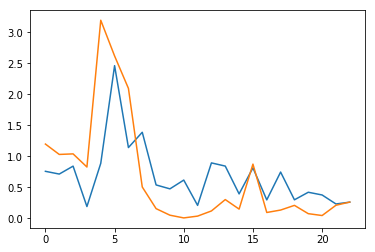

In [142]:
%matplotlib inline

plt.plot(range(scores.shape[0]), scores[:, 0].numpy())
plt.plot(range(scores.shape[0]), scores[:, 1].numpy())
plt.show()